Comparing merge-tests between 3.4 and 3.6. Day long simulation. Final comparison.

* Rivers turned on, key_ldfslp turned off, constant vertical mixing

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as NC
import numpy as np
import scipy.interpolate as sp
import math

import datetime

from salishsea_tools import stormtools, nc_tools, viz_tools

In [2]:
#load up the bathymetry. 
grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
bathy = grid.variables['Bathymetry'][:,:]
X = grid.variables['nav_lon'][:,:]
Y = grid.variables['nav_lat'][:,:]

In [3]:
#load in the datas. Trying something new with dict objects...

#first run (3.4)
r1 = 'three-four';
runname1 = '/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/final_NEMO34_NEMO36_compare/'
print runname1

#second run (3.6)
r2 = 'three-six'
runname2 = ('/ocean/sallen/allen/research/MEOPAR/nemo-3.6-code/NEMOGCM/CONFIG/SalishSea/'
            'EXP00/final_NEMO34_NEMO36_comparison/')
print runname2

runs = {r1: runname1, r2: runname2}


/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/final_NEMO34_NEMO36_compare/
/ocean/sallen/allen/research/MEOPAR/nemo-3.6-code/NEMOGCM/CONFIG/SalishSea/EXP00/final_NEMO34_NEMO36_comparison/


In [4]:
fUs={}; fVs={}; fTs={}
for key, path in runs.iteritems():
    if key == r1:
        fUs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121214_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121214_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121214_grid_T.nc','r');
    else:
        fUs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_T.nc','r');

Show info about the files

In [5]:
for key in runs:
    print key
    nc_tools.show_dataset_attrs(fUs[key])

three-four
file format: NETCDF4
Conventions: CF-1.1
production: An IPSL model
TimeStamp: 14/07/2015 13:09:02 -0700
file_name: SalishSea_1h_20121214_20121214_grid_U.nc
history: Tue Jul 14 13:11:40 2015: ncks -4 -L4 -O SalishSea_1h_20121214_20121214_grid_U.nc SalishSea_1h_20121214_20121214_grid_U.nc
NCO: 4.4.5
three-six
file format: NETCDF4
name: SalishSea_1h_20121214_20121215
description: ocean U grid variables
conventions: CF-1.1
production: An IPSL model
timeStamp: 2015-Jul-13 11:09:49 PDT


In [6]:
for key in runs:
    print key
    nc_tools.show_variable_attrs(fUs[key])

three-four
<type 'netCDF4.Variable'>
float32 depthu(depthu)
    axis: Z
    standard_name: model_level_number
    units: m
    positive: down
    valid_min: 0.5
    valid_max: 441.466
    title: depthu
    long_name: Vertical U levels
unlimited dimensions: 
current shape = (40,)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float32 nav_lat(y, x)
    standard_name: latitude
    units: degrees_north
    valid_min: 46.8606
    valid_max: 51.1056
    long_name: Latitude
    nav_model: Default grid
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float32 nav_lon(y, x)
    standard_name: longitude
    units: degrees_east
    valid_min: -126.397
    valid_max: -121.316
    long_name: Longitude
    nav_model: Default grid
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float64 time_counte

Different sizes because initial is 48 hours. 

In [7]:
#U,V,SSH,Salinity,Temperature
Us={}; Vs={}; Es={}; Ss={}; Ts={}; Ds={}
tims = {}
t_orig = {}
tim_count={}

for key in runs:
    Us[key] = fUs[key].variables['vozocrtx']
    Vs[key] = fVs[key].variables['vomecrty']
    Es[key] = fTs[key].variables['sossheig']
    Ss[key] = fTs[key].variables['vosaline']
    Ts[key] = fTs[key].variables['votemper']
    Ds[key] = fTs[key].variables['deptht']
    tim_count[key] = fUs[key].variables['time_counter']
    
t_orig[r1] = datetime.datetime.strptime(
                    tim_count[r1].time_origin.title(), ' %Y-%b-%d %H:%M:%S')
t_orig[r2] = datetime.datetime.strptime(
                tim_count[r2].time_origin.title(), '%Y-%m-%d %H:%M:%S')


#Comparison plots

Quick look at surface fields near the start adn end of first day

In [8]:
def plot_variable(t,depthlevel,var, var_name,vmin=-3,vmax=3,diffmin=-0.1, diffmax=0.1,figsize=(15,5),ssh_flag=False):
    #plot
    fig, axs=plt.subplots(1,3,figsize=figsize)
    for key,ax in zip(runs,axs[0:2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        if ssh_flag:
            mesh=ax.pcolormesh(var[key][t,:,:],vmin=vmin,vmax=vmax)
        else:
            mesh=ax.pcolormesh(var[key][t,depthlevel,:,:],vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)
    ax=axs[2]
    if ssh_flag:
        diff = var[r1][t,:,:]-var[r2][t,:,:]
    else:
        diff = var[r1][t,depthlevel,:,:]-var[r2][t,depthlevel,:,:]
    mesh = ax.pcolormesh(diff, vmin=diffmin, vmax=diffmax, cmap = 'bwr')
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)

Initial time, surface

Time = 0, depth level = 0


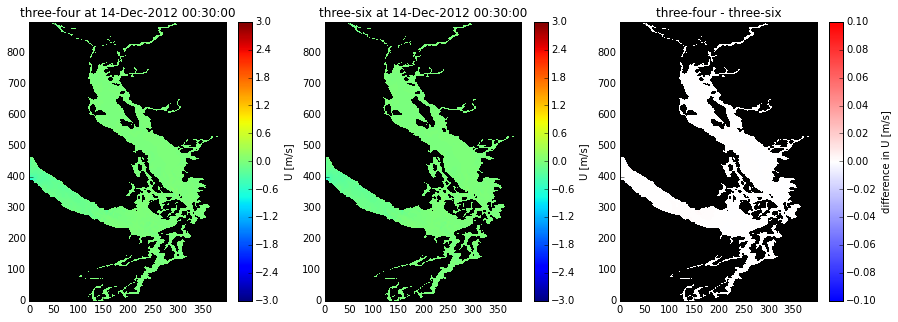

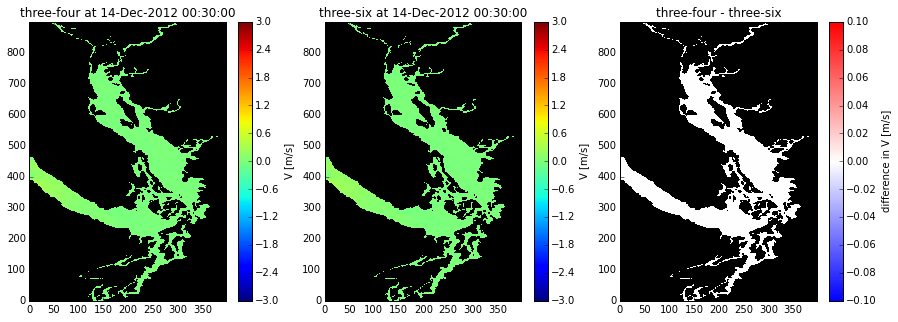

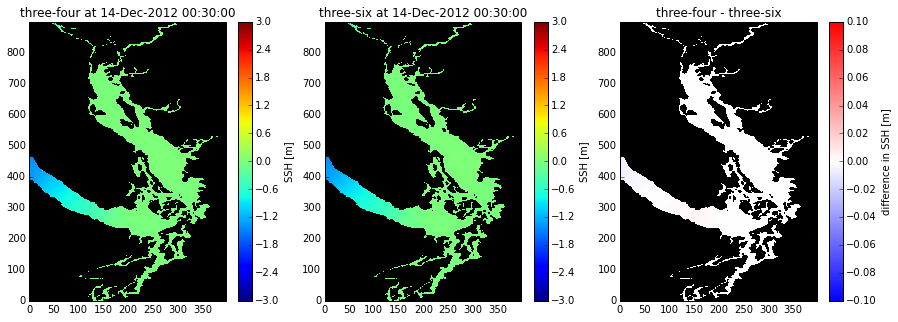

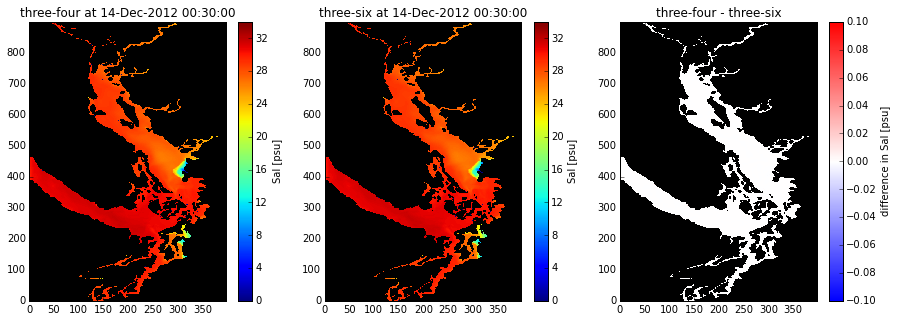

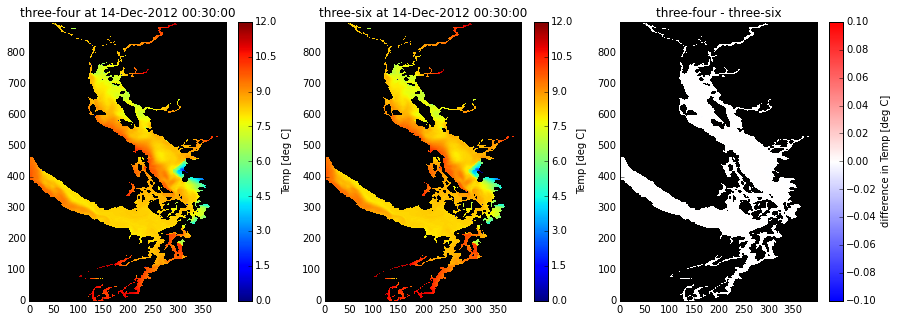

In [9]:
t=0
depthlevel=0

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

Minor differences in the U/V fields at the SJdF open boundary.  
2015/06/06: No differences at the 0.1 level in any fields.

Time = 23, depth level = 0


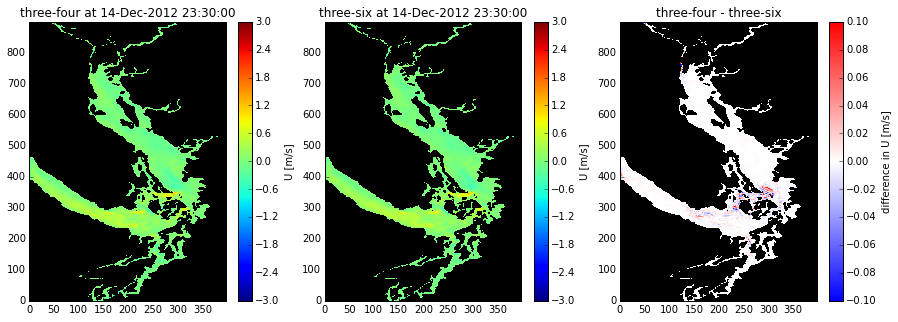

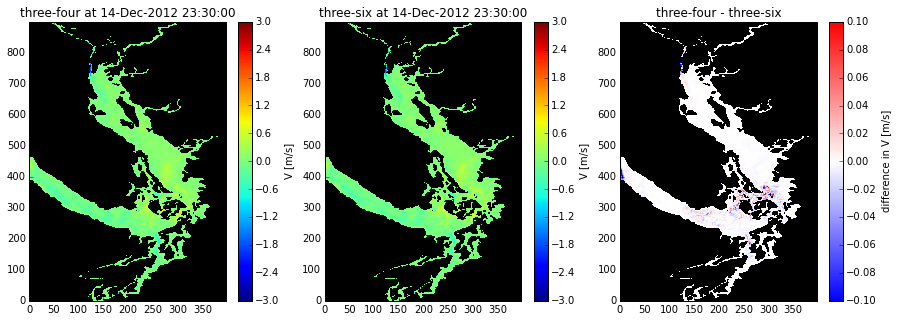

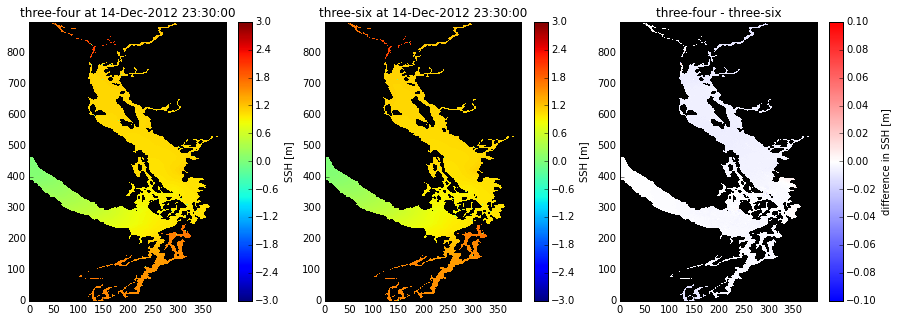

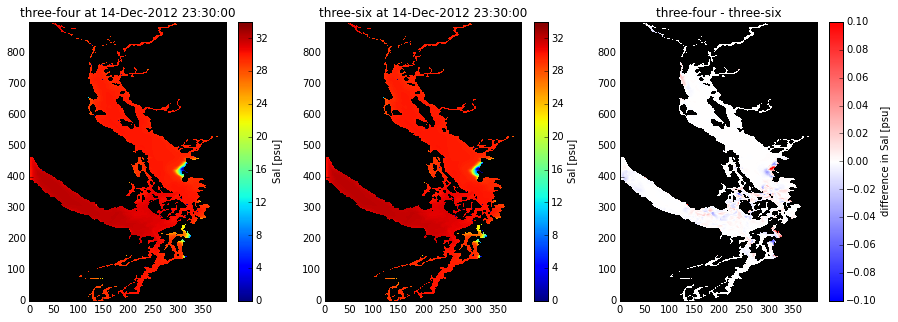

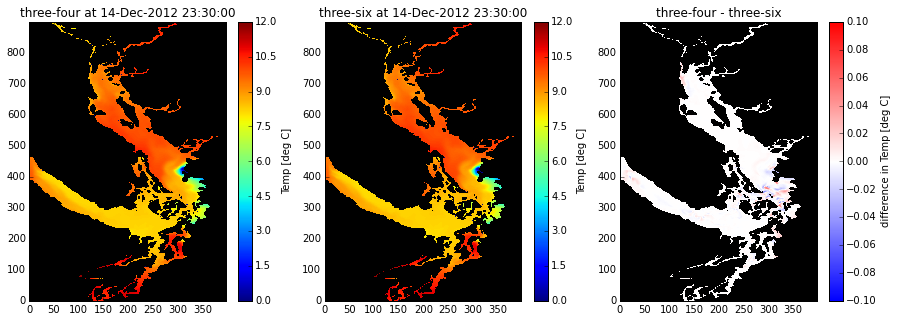

In [10]:
t=23
depthlevel=0

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

* Similar differences as in the no rivers case. 

# Profiles

In [11]:
def compare_profile(var,var_name, i,j,t,zmin=0,zmax=400,vmin=0,vmax=34):
    """Function to compare a variable over depth at point i,j and time t.
    Plots each sim on the same axis and then their difference over depth"""

    fig,axs=plt.subplots(1,2,figsize=(10,5))
    ax=axs[0]
    for key in runs:
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        ax.plot(var[key][t,:,j,i],Ds[key], '-o',label=key)
    ax.set_title(out.strftime('%d-%b-%Y %H:%M:%S'))
    ax.set_xlabel(var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])
    ax.set_xlim([vmin,vmax])
    ax.legend(loc=0)
    ax=axs[1]
    #difference    
    diff = var[r1][t,:,j,i]-var[r2][t,:,j,i]
    ax.plot(diff,Ds[key], '-ro')
    ax.set_title('Difference: ' +r1+' - ' +r2)
    ax.set_xlabel('Difference in ' + var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])

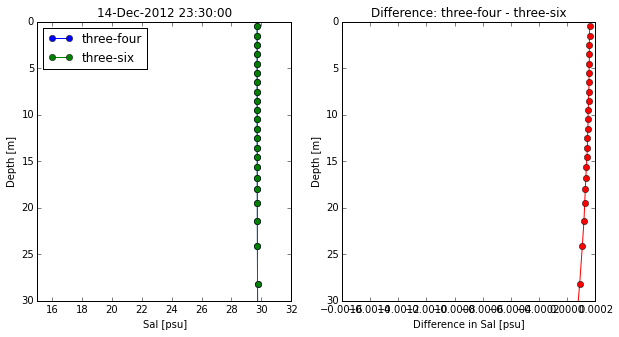

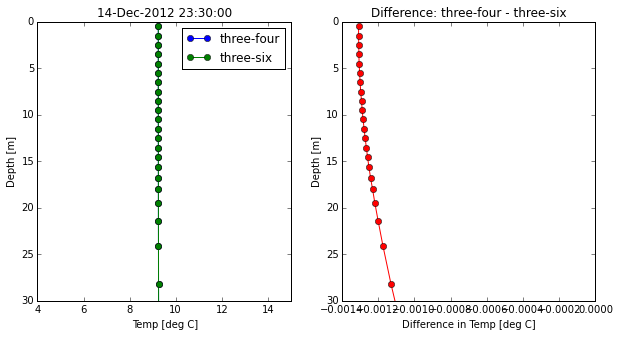

In [12]:
tp = 23
ip = 300
jp = 450
zmax=30
compare_profile(Ss,'Sal [psu]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=4,vmax=15)

* Central SoG

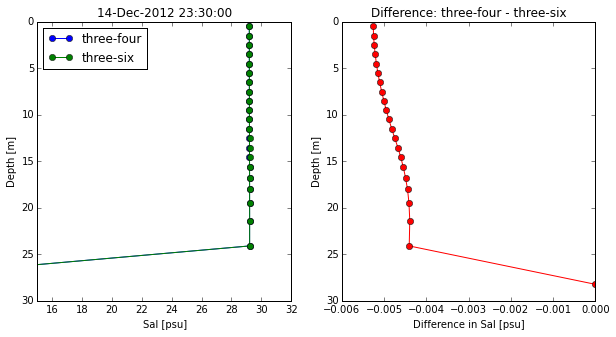

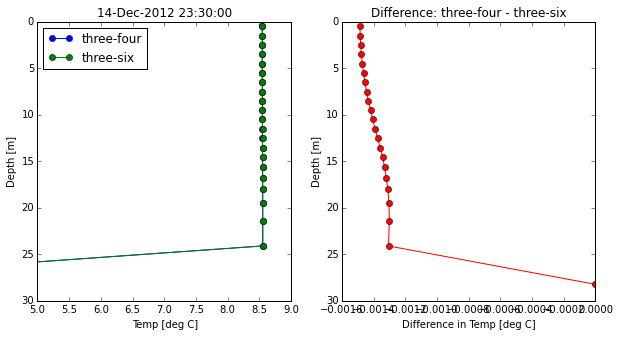

In [13]:
tp = 23
ip = 300
jp = 400
zmax=30
compare_profile(Ss,'Sal [psu]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=5,vmax=9)


* Closer to Boundary Pass

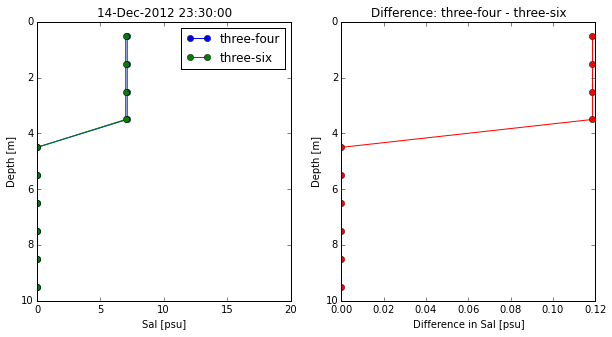

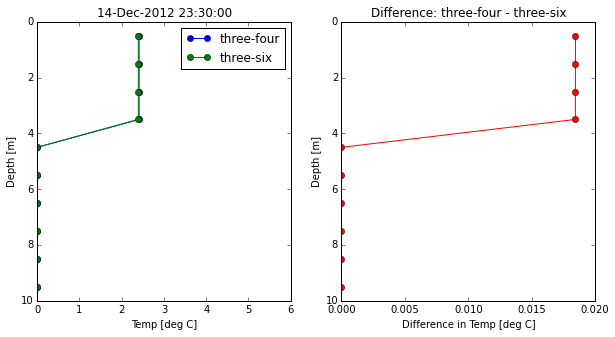

In [14]:
tp = 23
ip = 310
jp = 430
zmax=10
compare_profile(Ss,'Sal [psu]', ip,jp,tp,zmin=0,zmax=zmax,vmin=0,vmax=20)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=0,vmax=6)

* Right in plume
* 3.4 is a little bit saliter right plume area. There might be a small difference in how the rivers are treated but it doens't seem to affect the large scale

#Differences

Calculate simple staistics on the differences between fields. min/max/mean...

In [15]:
def summarize_differences(var,var_name,imin=0,imax=396,jmin=0,jmax=896):
    diff = var[r1][0:24,...,jmin:jmax+1,imin:imax+1]-var[r2][...,jmin:jmax+1,imin:imax+1]
    inds_min = np.argmin(diff); inds_min=np.unravel_index(inds_min,diff.shape)
    inds_max = np.argmax(diff); inds_max=np.unravel_index(inds_max,diff.shape)
    print var_name
    print 'min diff: {0:.3}, index {1}'.format(diff.min(),inds_min)
    print 'max diff: {0:.3}, index {1}'.format(diff.max(),inds_max)
    print 'mean diff {0:.3}'.format(diff.mean())

In [16]:
variables = {'U [m/s]': Us,  'V [m/s]': Vs, 'SSH [m]': Es, 'Sal [psu]': Ss, 'Temp [deg C]': Ts}
for key in variables:
    summarize_differences(variables[key],key)

V [m/s]
min diff: -1.68, index (9, 15, 771, 118)
max diff: 3.55, index (16, 0, 772, 119)
mean diff -1.28e-06
Temp [deg C]
min diff: -0.438, index (14, 0, 346, 292)
max diff: 0.406, index (12, 20, 348, 290)
mean diff 7.16e-05
SSH [m]
min diff: -2.22, index (21, 896, 41)
max diff: 2.7, index (3, 896, 41)
mean diff -0.00114
U [m/s]
min diff: -2.59, index (9, 0, 771, 117)
max diff: 3.3, index (9, 0, 773, 117)
mean diff -2.32e-06
Sal [psu]
min diff: -1.51, index (6, 3, 147, 311)
max diff: 0.771, index (18, 11, 749, 123)
mean diff -2.81e-05


* Mean diff is perhaps unfair because the fields aren't masked. So there are a whole lot of zeros
* U/V have largest differences near the north end of the domain.
* Large differences in ssh are probaly because of how the open boundary is treated. 3.4 has an extra layer of zeros at each boundary on the T grid. Perhpas this can explain the U/V differences too?
* Largest temp and salinity difference looks to be just after Boundary Pass at the surface.

Exclude layer surrounding the open boundaries

In [17]:
imin=2; imax=396
jmin=2; jmax=895
for key in variables:
    summarize_differences(variables[key],key,imin,imax,jmin,jmax)

V [m/s]
min diff: -1.68, index (9, 15, 769, 116)
max diff: 3.55, index (16, 0, 770, 117)
mean diff -4.36e-07
Temp [deg C]
min diff: -0.438, index (14, 0, 344, 290)
max diff: 0.406, index (12, 20, 346, 288)
mean diff 7.22e-05
SSH [m]
min diff: -0.306, index (10, 771, 115)
max diff: 0.268, index (8, 770, 118)
mean diff -0.00116
U [m/s]
min diff: -2.59, index (9, 0, 769, 115)
max diff: 3.3, index (9, 0, 771, 115)
mean diff -2.59e-06
Sal [psu]
min diff: -1.51, index (6, 3, 145, 309)
max diff: 0.771, index (18, 11, 747, 121)
mean diff -2.83e-05


#Bounday conditions on SSH

How do the ssh/u/v near the boundaries compare?

In [18]:
sshs={}
us={}
vs={}
i=1
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
        

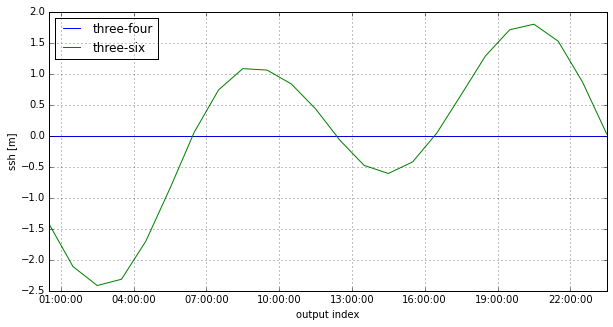

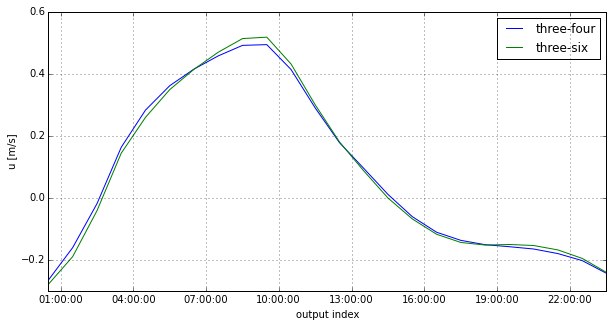

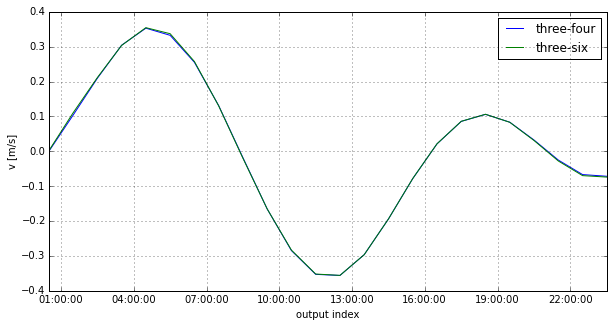

In [19]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Why is second index zero in initial but not three-six.

Next to boundary

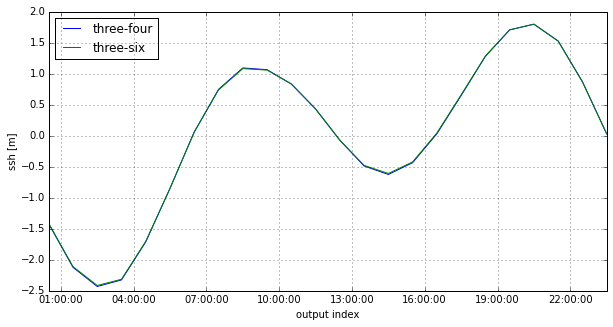

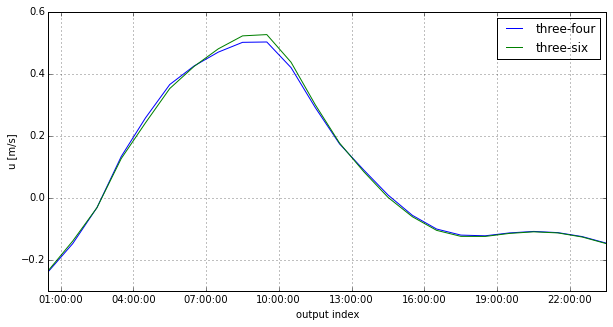

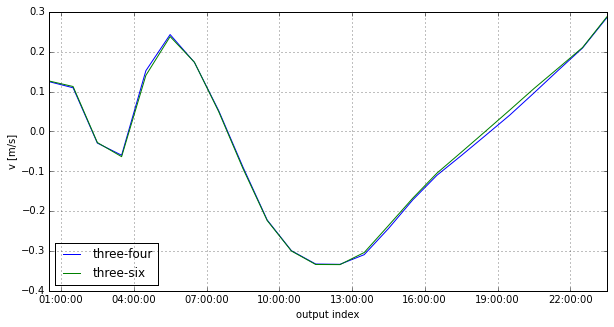

In [20]:
sshs={}
us={}
vs={}
i=2
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

North

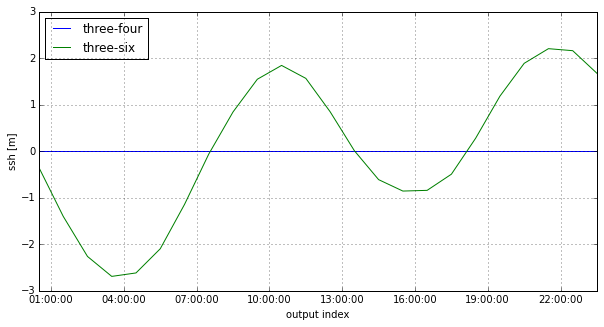

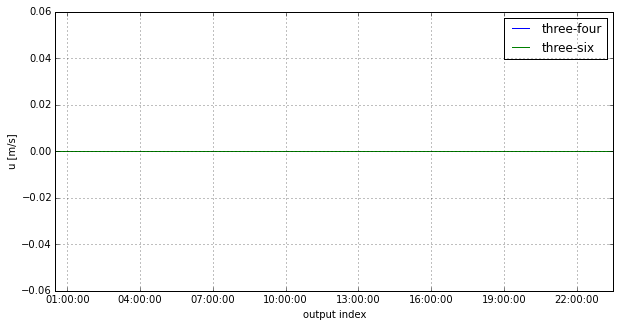

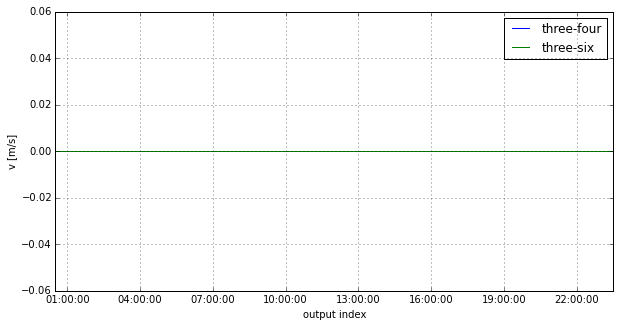

In [21]:
sshs={}
us={}
vs={}
i=50
j=896
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Same here. At the north, initial has two points on the T grid that are zero...

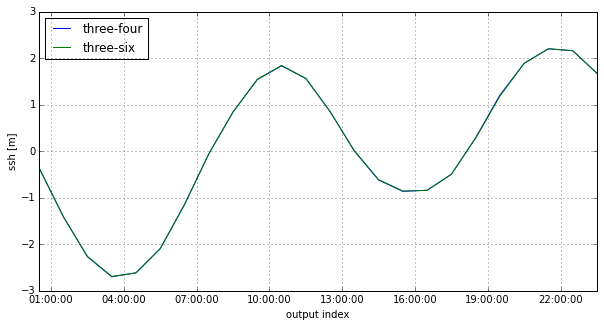

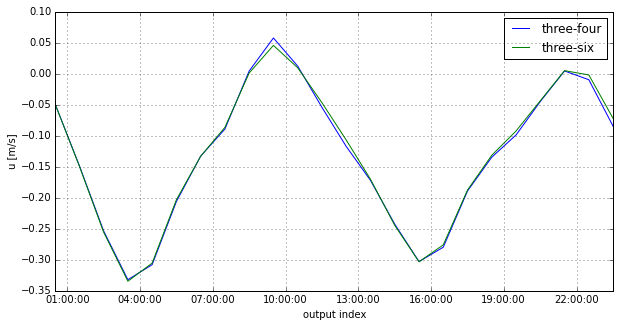

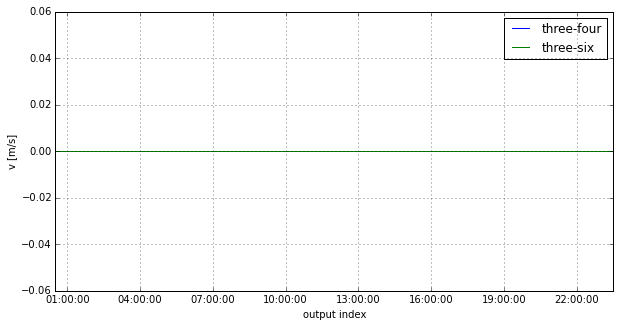

In [22]:
sshs={}
us={}
vs={}
i=50
j=895
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Phases align!

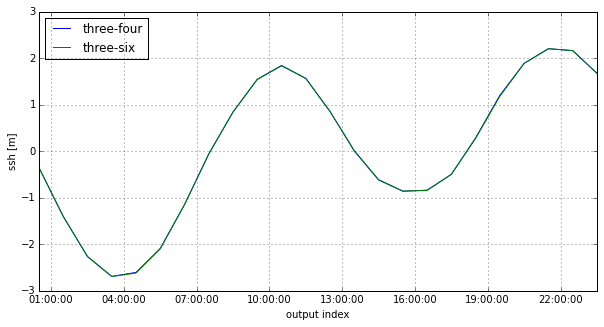

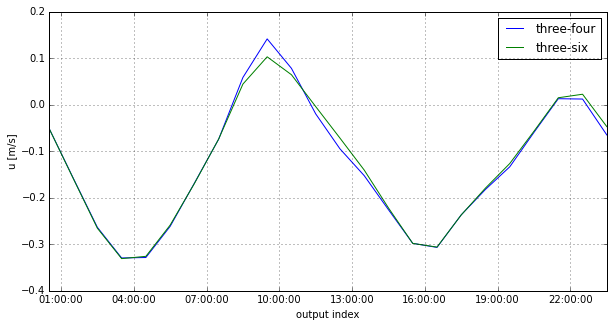

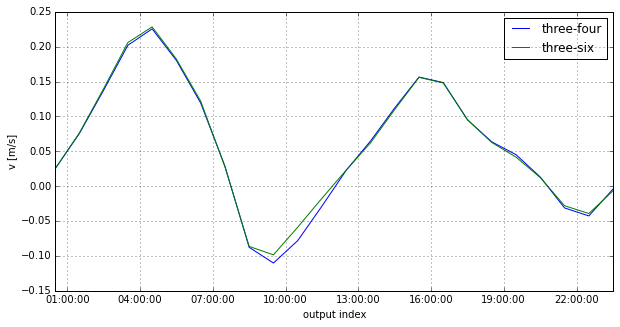

In [23]:
sshs={}
us={}
vs={}
i=50
j=894
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

# Closer look at currents at SJdF boundary

Compare fields over depth and along the JdF boundary

In [24]:
def compare_boundary(var, var_name, irange, jrange, t,vmin=-1,vmax=1,diffmin=-0.5,diffmax=0.5):
    fig,axs=plt.subplots(1,3,figsize=(15,3))
    
    for ax, key in zip(axs[0:2],[r1,r2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        masked_var = np.ma.masked_values(var[key][t,:,jrange,irange],0)
        mesh=ax.pcolormesh(masked_var,vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        ax.invert_yaxis()

    ax=axs[2]
    diff = var[r1][t,:,jrange,irange]-var[r2][t,:,jrange,irange]
    diff=np.ma.masked_values(diff,0)
    mesh = ax.pcolormesh(diff,vmin=diffmin,vmax=diffmax)
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    ax.invert_yaxis()

Early time

Mouth of JdF at t = 0


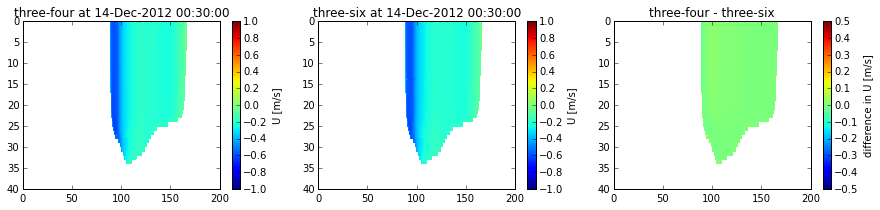

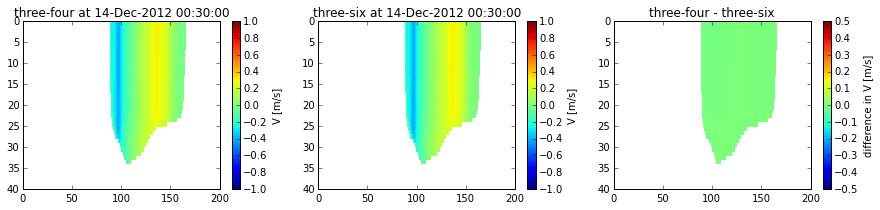

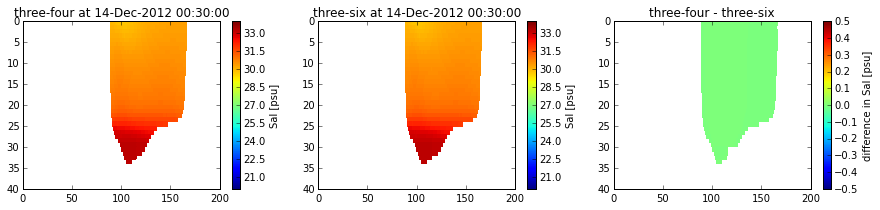

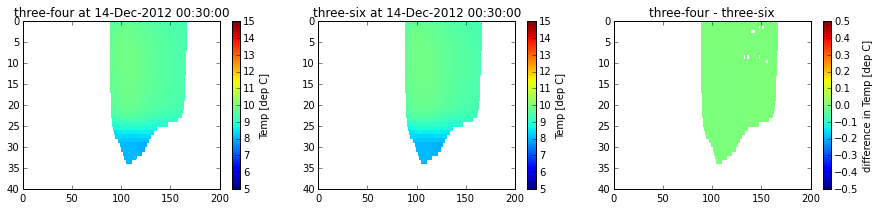

In [25]:
t=0
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)

Max difference time

Mouth of JdF at t = 5


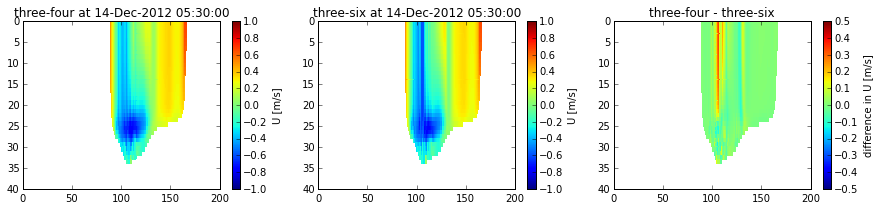

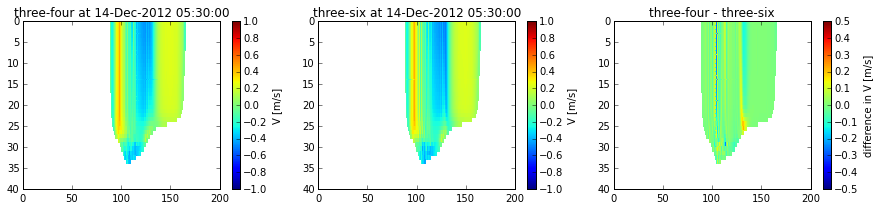

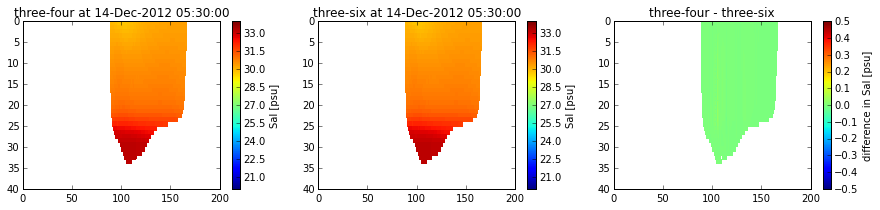

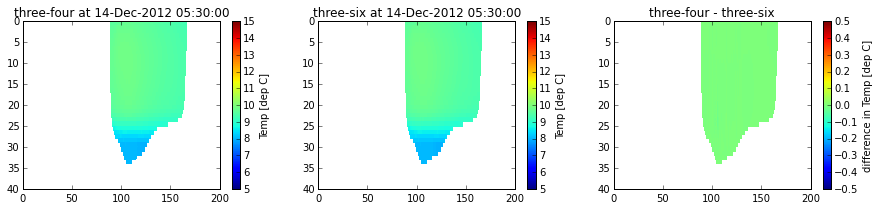

In [26]:
t=5
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)

Last time

Mouth of JdF at t = 23


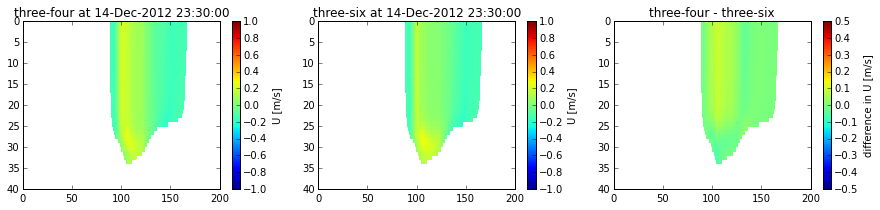

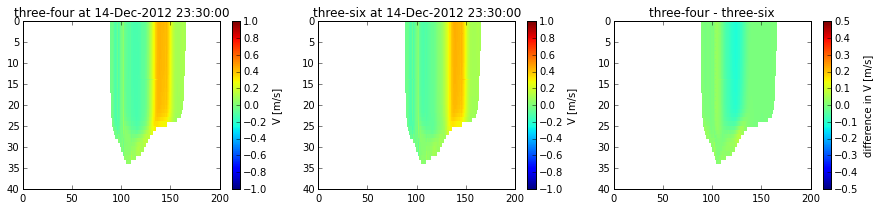

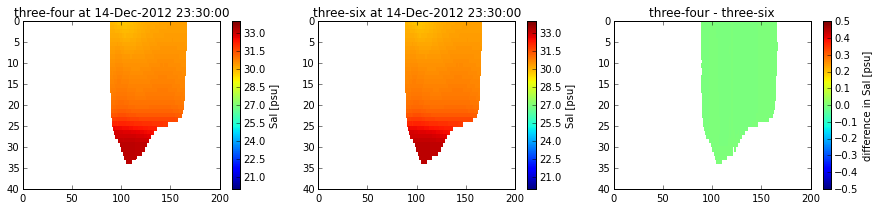

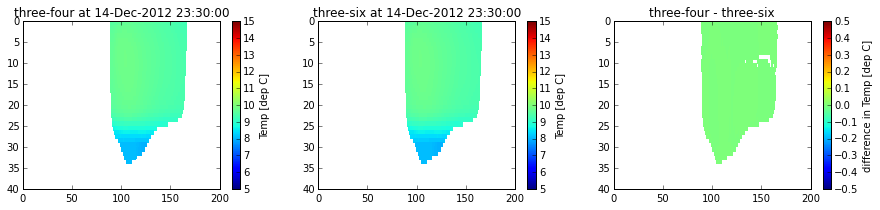

In [27]:
t=23
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)

* Note, we both turned left the rivers turned off in this case. 

Overall, not much different from the no rivers case. 

Areas where the 3.4 and 3.6 differ:
* Boundary Pass
* Plume
* Johnstone Strait
* Some close to open boundary

Note the SSH is a few cm lower in the north SoG for 3.6. This also occured in the no rivers.